In [52]:
import numpy as np
import matplotlib.pylab as plt

In [53]:
np.set_printoptions(precision=4, suppress=True)

In [54]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

In [55]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [56]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [57]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 One-hot 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [58]:
class TwoLayerNet:
    """
      A two-layer fully-connected neural network. The net has an input dimension of
      N, a hidden layer dimension of H, and performs classification over C classes.
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        가중치 초기화
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num # error or loss
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [59]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


In [60]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

* 형상 출력해보기

In [61]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

### 학습하기

* Hyperparameters

In [62]:
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

In [63]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

* Train the network !

In [64]:
# 1에폭당 반복 수
iter_per_epoch = max(train_size // batch_size, 1)
print('iter_per_epoch = {}//{}={}'.format(train_size, batch_size,iter_per_epoch))

iter_per_epoch = 60000//100=600


In [65]:
for key in ('W1', 'b1', 'W2', 'b2'):
    print(key)

W1
b1
W2
b2


In [66]:
print('epoch\tloss\tacc_trn\tacc_test')
print('---------------------------------')
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print('{}\t{:.3f}\t{:.3f}\t{:.3f}'.format(i//iter_per_epoch, loss, train_acc, test_acc))
        

epoch	loss	acc_trn	acc_test
---------------------------------
0	2.288	0.112	0.114
1	0.840	0.790	0.793
2	0.500	0.875	0.879
3	0.260	0.897	0.899
4	0.319	0.908	0.911
5	0.318	0.915	0.916
6	0.199	0.920	0.920
7	0.255	0.924	0.924
8	0.202	0.928	0.929
9	0.288	0.932	0.932
10	0.127	0.935	0.935
11	0.372	0.938	0.937
12	0.198	0.940	0.938
13	0.110	0.942	0.941
14	0.187	0.944	0.942
15	0.130	0.945	0.943
16	0.228	0.948	0.946


### 결과 그려보기 및 분석

Text(0, 0.5, 'loss')

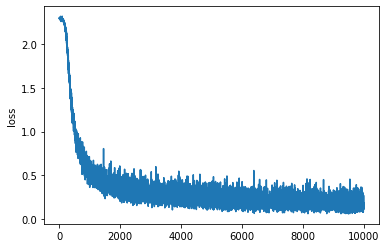

In [67]:
plt.plot(train_loss_list)
plt.ylabel('loss')

* Train accuracy

In [68]:
train_acc = network.accuracy(x_train, t_train)
print(train_acc)

0.9491833333333334


* Test accuracy

In [69]:
test_acc = network.accuracy(x_test, t_test)
print(test_acc)

0.946


* 하나만 테스트해보기
: 그림 그리는 과정은 03_NeuralNetwork/01_3_NN_MNIST_Exploration.ipynb 을 참고해보세요

In [70]:
idx_to_test = 550+1 #0~9999 바꾸어서 해보세요
x1 = x_test[idx_to_test]
t1 = t_test[idx_to_test]

In [71]:
x1.shape, t1.shape

((784,), (10,))

In [72]:
title = '#{} - {} / {}'.format(idx_to_test, np.argmax(t1), t1)
print(title)

#551 - 7 / [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [73]:
img = x1.reshape((28,28))

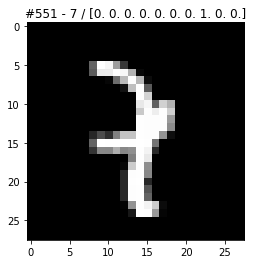

In [74]:
#plt.plot(img)


plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

In [75]:
y1 = network.predict(x1)

In [76]:
print(y1)

[0.     0.7268 0.0177 0.0701 0.0095 0.0012 0.0011 0.1393 0.0082 0.026 ]


In [77]:
print(t1) # 정답
print(y1) # 학습된 neural network 가 구한 값. 

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.     0.7268 0.0177 0.0701 0.0095 0.0012 0.0011 0.1393 0.0082 0.026 ]


In [78]:
print('index\t정답\t예측값')
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t1[i], y1[i]))

index	정답	예측값
#0	0.0	0.000
#1	0.0	0.727
#2	0.0	0.018
#3	0.0	0.070
#4	0.0	0.010
#5	0.0	0.001
#6	0.0	0.001
#7	1.0	0.139
#8	0.0	0.008
#9	0.0	0.026


In [79]:
np.argmax(t1) == np.argmax(y1) 

False

### TODO

* idx_to_test 를 바꾸어 가며 테스트해보고 결과값 논의해보기 (3개 이상)
```
예를들면 네트워크가 약간이라도 확률을 만들어내는 숫자 분석을 해볼수 있음. 
: 7과 1이 비슷하기에 정답은 7이지만 1에도 약간의 확률값이 생겼다.
```
* Training 이 되기 전에는 어떻게 예측을 하는지 해보기

In [80]:
idx_to_test = 550+2000 #0~9999 바꾸어서 해보세요
x2 = x_test[idx_to_test]
t2 = t_test[idx_to_test]
title = '#{} - {} / {}'.format(idx_to_test, np.argmax(t2), t2)
print(title)

#2550 - 8 / [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [81]:
img = x2.reshape((28,28))

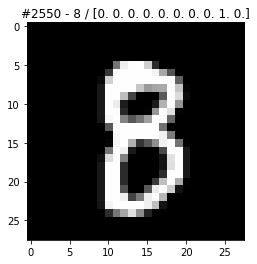

In [82]:
#plt.plot(img)


plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

숫자가 클리어하게 8으로 보여서 학습을 시켜도 제대로 정답을 보낼거같다!

In [83]:
y2 = network.predict(x2)
print(y2)

[0.0045 0.0001 0.0034 0.0437 0.0001 0.0227 0.0001 0.0003 0.8833 0.042 ]


In [84]:
print(t2) # 정답
print(y2) # 학습된 neural network 가 구한 값. 

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0.0045 0.0001 0.0034 0.0437 0.0001 0.0227 0.0001 0.0003 0.8833 0.042 ]


In [85]:
print('index\t정답\t예측값')
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t2[i], y2[i]))

index	정답	예측값
#0	0.0	0.005
#1	0.0	0.000
#2	0.0	0.003
#3	0.0	0.044
#4	0.0	0.000
#5	0.0	0.023
#6	0.0	0.000
#7	0.0	0.000
#8	1.0	0.883
#9	0.0	0.042


In [86]:
np.argmax(t2) == np.argmax(y2) 

True

위에 보면 정답과 예측값이 true인걸 확인이 가능한데, 예측값이 8에 0.88로 가장 높다.

In [88]:
idx_to_test = 550+3000 #0~9999 바꾸어서 해보세요
x2 = x_test[idx_to_test]
t2 = t_test[idx_to_test]
title = '#{} - {} / {}'.format(idx_to_test, np.argmax(t2), t2)
print(title)

#3550 - 6 / [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [89]:
img = x2.reshape((28,28))

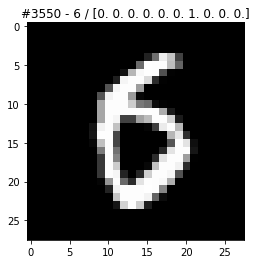

In [90]:
#plt.plot(img)


plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

조금 비뚤어졌지만 6에 가까워 보인다.

In [91]:
y2 = network.predict(x2)
print(y2)

[0.1412 0.0001 0.0014 0.0023 0.0008 0.536  0.3108 0.0006 0.005  0.0019]


In [92]:
print(t2) # 정답
print(y2) # 학습된 neural network 가 구한 값. 

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.1412 0.0001 0.0014 0.0023 0.0008 0.536  0.3108 0.0006 0.005  0.0019]


In [93]:
print('index\t정답\t예측값')
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t2[i], y2[i]))

index	정답	예측값
#0	0.0	0.141
#1	0.0	0.000
#2	0.0	0.001
#3	0.0	0.002
#4	0.0	0.001
#5	0.0	0.536
#6	1.0	0.311
#7	0.0	0.001
#8	0.0	0.005
#9	0.0	0.002


In [94]:
np.argmax(t2) == np.argmax(y2)

False

예측 값을 확인해보면 0.536으로 거의 50%에 가까운 확률로 5라고 예측을 했는데 조금 의외였다. 사람이 볼때는 6인데
컴퓨터가 예상한 숫자는 5이다. 어핏보면 5에 가까운 요소들이 많으나 5가 대략 50%이고 6이 30%인걸 보아 컴퓨터는 거의 찍었다고 봐도 괜찮은 숫자이다. 

In [95]:
idx_to_test = 550+5000 #0~9999 바꾸어서 해보세요
x2 = x_test[idx_to_test]
t2 = t_test[idx_to_test]
title = '#{} - {} / {}'.format(idx_to_test, np.argmax(t2), t2)
print(title)

#5550 - 1 / [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [96]:
img = x2.reshape((28,28))

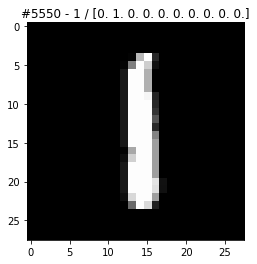

In [97]:
#plt.plot(img)


plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

아무리 잘못봐도 이건 정답을 1로 예측할거같다.

In [98]:
y2 = network.predict(x2)
print(y2)

[0.     0.9975 0.0001 0.0009 0.     0.0002 0.0001 0.0002 0.0008 0.0001]


In [99]:
print(t2) # 정답
print(y2) # 학습된 neural network 가 구한 값. 

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.     0.9975 0.0001 0.0009 0.     0.0002 0.0001 0.0002 0.0008 0.0001]


In [100]:
print('index\t정답\t예측값')
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t2[i], y2[i]))

index	정답	예측값
#0	0.0	0.000
#1	1.0	0.998
#2	0.0	0.000
#3	0.0	0.001
#4	0.0	0.000
#5	0.0	0.000
#6	0.0	0.000
#7	0.0	0.000
#8	0.0	0.001
#9	0.0	0.000


In [101]:
np.argmax(t2) == np.argmax(y2)

True

확인한 결과 내 예상과 같이 1에 0.998로 거의 100%에 가까운 예측값을 내보냈다.

### References

* Stanford CS231n, Two-layer network <br>
https://cs231n.github.io/
https://github.com/yunjey/cs231n/blob/master/assignment1/cs231n/classifiers/neural_net.py

* 주교재 <br /> https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/train_neuralnet.py